<h1 align="center">Plant Seedlings Classification</h1>

<center><p float="center">
  <img src="https://scx2.b-cdn.net/gfx/news/2022/farming-practices-good.jpg" width="700" height="300"/>

### Problem Statement

Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 different species.

The dataset can be download from Olympus.
The data file names are:
images.npy
Label.csv
Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

The goal of the project is to create a classifier capable of determining a plant's species from an image.

List of Species

* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common Wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
Sugar beet

### Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images = np.load('/content/drive/My Drive/images.npy')
labels = pd.read_csv('/content/drive/My Drive/Labels.csv')

### Understanding shape of Datasets

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.

### Plotting images using OpenCV and matplotlib

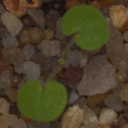

In [5]:
cv2_imshow(images[5])

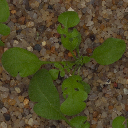

In [6]:
cv2_imshow(images[1000])

### Exploratory Data Analysis

In [7]:
def plot_images(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

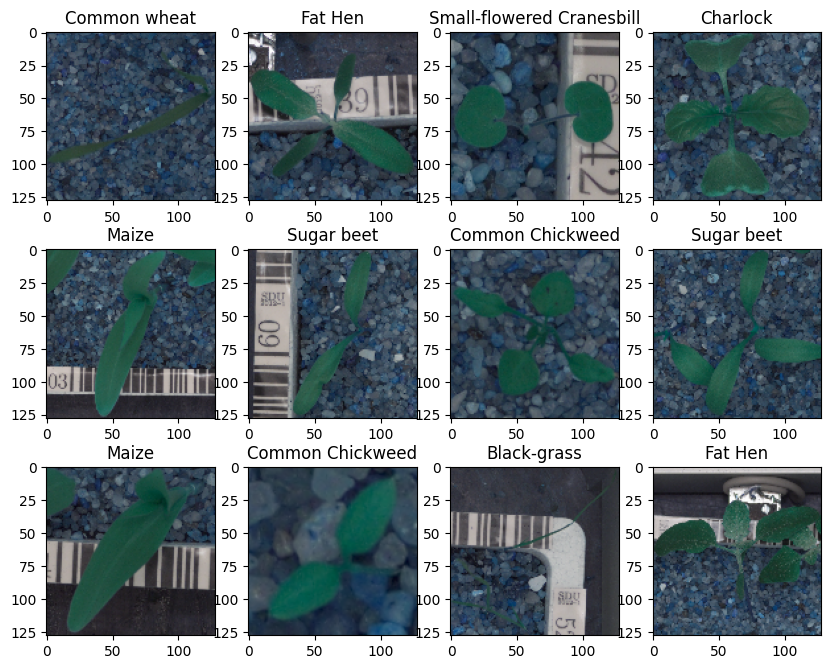

In [8]:
plot_images(images,labels)

### Checking the distribution of the target variable

In [9]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

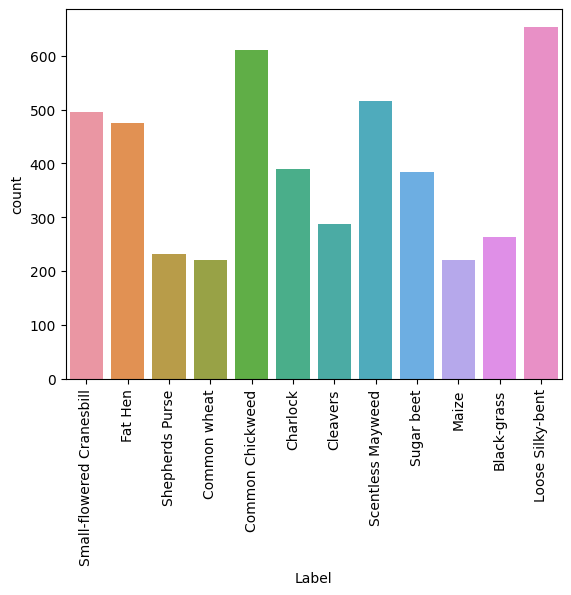

In [10]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

* There are 12 labels in all
* All labels have an average count of 200.
* There is imbalance in the distribution but its not an intensive one

### Data Pre-Processing

#### Converting the BGR images to RGB images.

In [11]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

#### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [12]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

##### Image before resizing

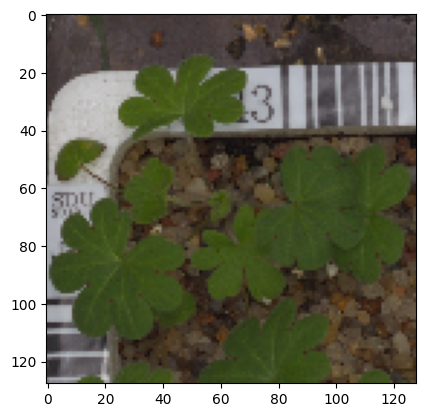

In [13]:
plt.imshow(images[3])

##### Image after resizing

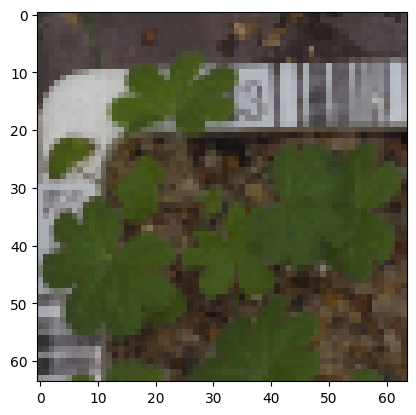

In [14]:
plt.imshow(images_decreased[3])

* We succesfully resized our image

### Data Preparation for Modeling

#### Splitting Dataset

* As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
* We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [15]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [16]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


* We successfully split our data

#### Encoding the target labels

In [17]:
# Convert labels from names to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

#### Data Normalization

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [18]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


### Model Building

Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [19]:
# Clearing backend
backend.clear_session()

In [20]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [21]:
# Intializing a sequential model
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Flatten())

model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(12, activation='softmax'))

opt=Adam()

model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

#### Fitting the model on the train data

In [22]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/50
121/121 - 13s - loss: 2.4546 - accuracy: 0.1045 - val_loss: 2.4374 - val_accuracy: 0.1379 - 13s/epoch - 111ms/step
Epoch 2/50
121/121 - 1s - loss: 2.3772 - accuracy: 0.1760 - val_loss: 2.0812 - val_accuracy: 0.3411 - 839ms/epoch - 7ms/step
Epoch 3/50
121/121 - 1s - loss: 2.0755 - accuracy: 0.2914 - val_loss: 1.8045 - val_accuracy: 0.3785 - 825ms/epoch - 7ms/step
Epoch 4/50
121/121 - 1s - loss: 1.9023 - accuracy: 0.3296 - val_loss: 1.7428 - val_accuracy: 0.3832 - 794ms/epoch - 7ms/step
Epoch 5/50
121/121 - 1s - loss: 1.8077 - accuracy: 0.3449 - val_loss: 1.6813 - val_accuracy: 0.3972 - 818ms/epoch - 7ms/step
Epoch 6/50
121/121 - 1s - loss: 1.7290 - accuracy: 0.3538 - val_loss: 1.5351 - val_accuracy: 0.4650 - 815ms/epoch - 7ms/step
Epoch 7/50
121/121 - 1s - loss: 1.6911 - accuracy: 0.3676 - val_loss: 1.4853 - val_accuracy: 0.4369 - 821ms/epoch - 7ms/step
Epoch 8/50
121/121 - 1s - loss: 1.6206 - accuracy: 0.3826 - val_loss: 1.3866 - val_accuracy: 0.5000 - 853ms/epoch - 7ms/step

#### Model Evaluation

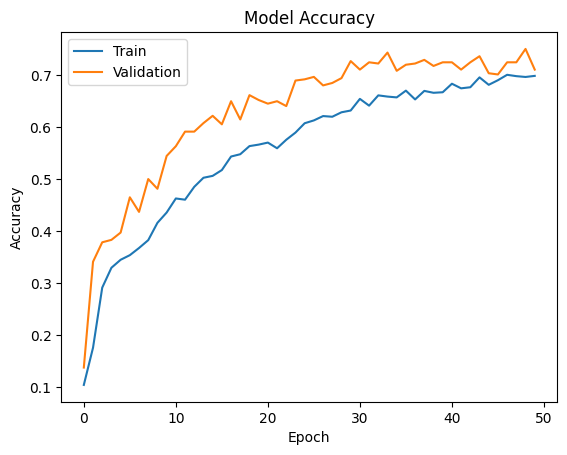

In [23]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Observations:

* We can see from the above plot that the training accuracy of the model was good but the validation accuracy was not good.
* The model seems to overfit on the data.

#### Evaluating the model on test data

In [24]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.0676 - accuracy: 0.7137 - 294ms/epoch - 20ms/step


#### Generating the predictions using test data

In [25]:
y_pred=model1.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


In [26]:
y_pred

array([[8.7265492e-38, 3.4580311e-23, 1.7435850e-36, ..., 8.1333521e-05,
        3.1575974e-21, 7.0922302e-05],
       [2.1163411e-19, 1.5275180e-03, 5.0240650e-04, ..., 1.5373940e-02,
        9.8244780e-01, 1.4050223e-04],
       [1.7132598e-15, 2.6861017e-03, 1.8972339e-03, ..., 2.0439493e-02,
        9.7398764e-01, 9.1973552e-04],
       ...,
       [2.9644158e-01, 1.6442034e-14, 1.4810432e-10, ..., 3.1456001e-17,
        5.1219655e-17, 4.8418021e-09],
       [3.8931631e-12, 1.8916400e-06, 1.4701938e-05, ..., 1.8841257e-02,
        3.5553198e-09, 1.0043734e-03],
       [1.1508904e-14, 1.7233299e-07, 8.2533987e-08, ..., 7.1833718e-01,
        2.1158485e-05, 1.8358082e-02]], dtype=float32)

#### Plotting the Confusion Matrix

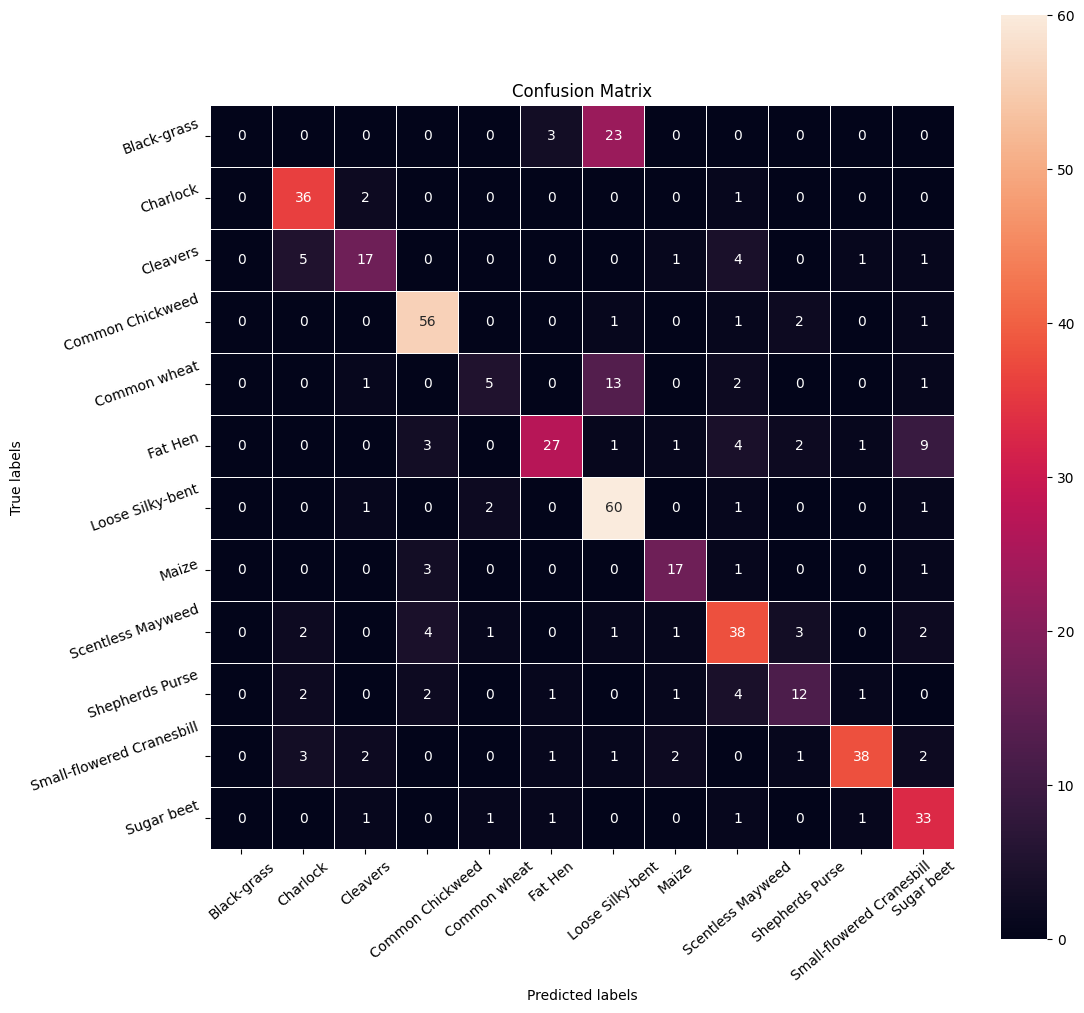

In [27]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

##### Observations

* We observe that some of the classes are not predicted correctly.
* In comparison to the rest, we can see that  Charlock,sherperds Purse are classified well
* We can also observe the rest of the classes are mostly misclassified.

##### Plotting Classification Report

In [28]:
# Plotting the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.75      0.92      0.83        39
           2       0.71      0.59      0.64        29
           3       0.82      0.92      0.87        61
           4       0.56      0.23      0.32        22
           5       0.82      0.56      0.67        48
           6       0.60      0.92      0.73        65
           7       0.74      0.77      0.76        22
           8       0.67      0.73      0.70        52
           9       0.60      0.52      0.56        23
          10       0.90      0.76      0.83        50
          11       0.65      0.87      0.74        38

    accuracy                           0.71       475
   macro avg       0.65      0.65      0.64       475
weighted avg       0.68      0.71      0.69       475



* The Model is giving us an accuracy 71
* The model seems to be predicting the 10th class very well

### Model Performance Improvement

Reducing the Learning Rate:

ReduceLRonPlateau() is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [29]:
#monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Data Augmentation

In [30]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [32]:
# Intializing a sequential model
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(12, activation='softmax'))

opt='Adam'

model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

##### Fitting the model on the train data

In [33]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 9s 81ms/step - loss: 2.1187 - accuracy: 0.2543 - val_loss: 2.3963 - val_accuracy: 0.1729 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 84ms/step - loss: 1.6437 - accuracy: 0.4277 - val_loss: 2.2683 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 6s 103ms/step - loss: 1.4396 - accuracy: 0.4914 - val_loss: 2.2402 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 4s 69ms/step - loss: 1.3770 - accuracy: 0.5178 - val_loss: 2.0626 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 6s 94ms/step - loss: 1.2670 - accuracy: 0.5443 - val_loss: 1.8457 - val_accuracy: 0.6706 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 77ms/step - loss: 1.1826 - accuracy: 0.5765 - val_loss: 1.7943 - val_accuracy: 0.4509 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 5s 86ms/step - loss: 1.

#### Model Evaluation

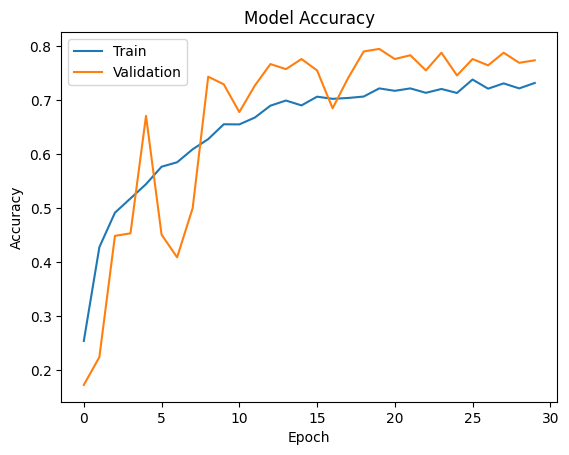

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* From our plot above we can see that the ovefitting has reduced immensely as compared to the previous model.

##### Evaluate the model on test data

In [35]:
accuracy = model2.evaluate(X_test_normalized,y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8031 - accuracy: 0.7474 - 136ms/epoch - 9ms/step


* The accuracy increased a bit and we were able to deal with overfitting

##### Plotting the Confusion Matrix

In [36]:
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


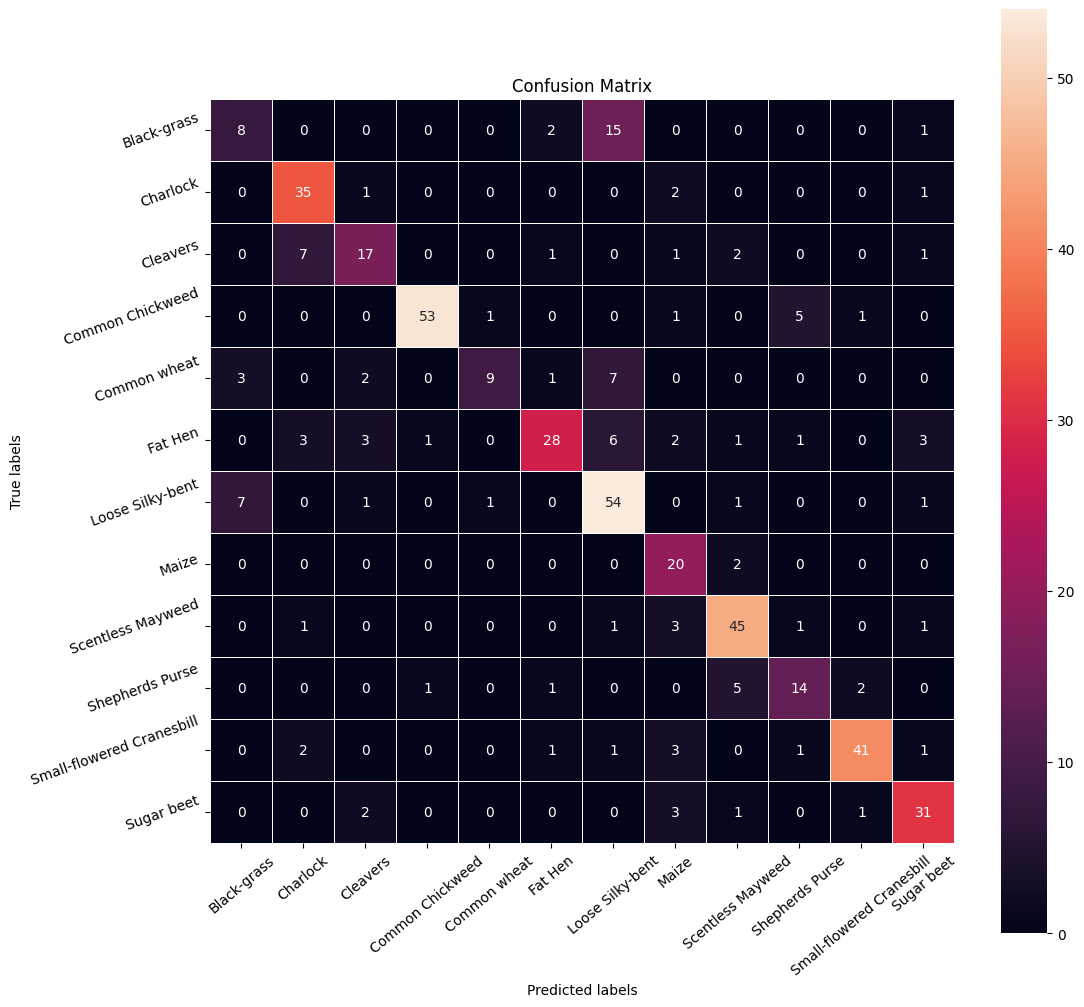

In [37]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

* From the Confusion matrix, majority of the classes were predicted correctly
* Black grass is one of the classes that the model isn't predicting well

#### Plotting Classification Report

In [38]:
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.44      0.31      0.36        26
           1       0.73      0.90      0.80        39
           2       0.65      0.59      0.62        29
           3       0.96      0.87      0.91        61
           4       0.82      0.41      0.55        22
           5       0.82      0.58      0.68        48
           6       0.64      0.83      0.72        65
           7       0.57      0.91      0.70        22
           8       0.79      0.87      0.83        52
           9       0.64      0.61      0.62        23
          10       0.91      0.82      0.86        50
          11       0.78      0.82      0.79        38

    accuracy                           0.75       475
   macro avg       0.73      0.71      0.71       475
weighted avg       0.76      0.75      0.74       475



* The Acuuracy has increased from the previous model.
* The precision and recall for some classes are high while some are low.
* But as compared to the previous model, this model seems to be better.

### Final Model

* For our First Model, our accuracy was low and the model was also overfitting.
* After we performed our data augmentation our second model seemed to handle the overfitting very well and also the accuracy increased.
* So therefore, we will use the second Model as our final one since it is less overfitting and also giving us a better accuracy.

#### Visualizing the prediction

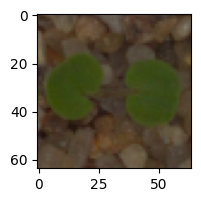

1/1 [==============================] - 0s 86ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


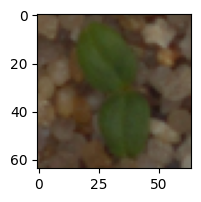

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Cleavers']
True Label Cleavers


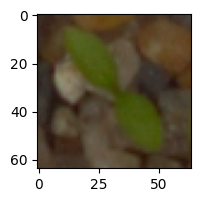

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


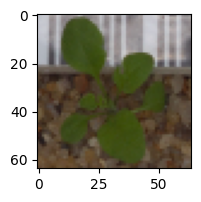

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [39]:

plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
# reshaping the input image as we are only trying to predict using a single image
# using inverse_transform() to get the output label from the output vector
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()

print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()

print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[59])

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()

print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[36])

* Our Model is correctly predicting the classes from our data.
* All three examples from the test data were predicted correctly using our final model.

### Actionable Insights and Business Recommendations

* These models can be further improved by training with different filter sizes and different number of filters.
* These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
* Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
* Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.